# k-NN con MNIST y Fashion-MNIST (Colab)
- Clasificación con k-Nearest Neighbors (k-NN)
- Visualización de ejemplos
- Validación: GridSearchCV, validation curve y learning curve


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from tensorflow.keras.datasets import mnist, fashion_mnist

# Reproducibilidad y estilo
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (7.5, 5.5)
plt.rcParams["axes.grid"] = True

def show_grid(images, labels=None, nrows=5, ncols=5, title=None, cmap="gray"):
    """Mosaico nrows x ncols de imágenes (28x28)."""
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    idxs = np.random.choice(len(images), size=nrows*ncols, replace=False)
    for ax, i in zip(axes.ravel(), idxs):
        ax.imshow(images[i], cmap=cmap)
        ax.axis("off")
        if labels is not None:
            ax.set_title(str(labels[i]), fontsize=10)
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def make_knn_pipeline(n_neighbors=5, weights="uniform", p=2):
    """Pipeline: flatten (implícito) + StandardScaler + KNN.
       *StandardScaler*  normalizamos a [0,1].
    """
    # Nota: kNN usa distancia Euclídea por defecto (p=2), pueden usar cualquier p.
    return Pipeline([
        ("sc", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p))
    ])

## MNIST
- Imágenes 28x28 de dígitos (0–9).
- Normalizamos a [0,1] y aplanamos para k-NN (vectores de 784).
- Submuestreamos train para que k-NN sea rápido (p. ej., 12k).


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


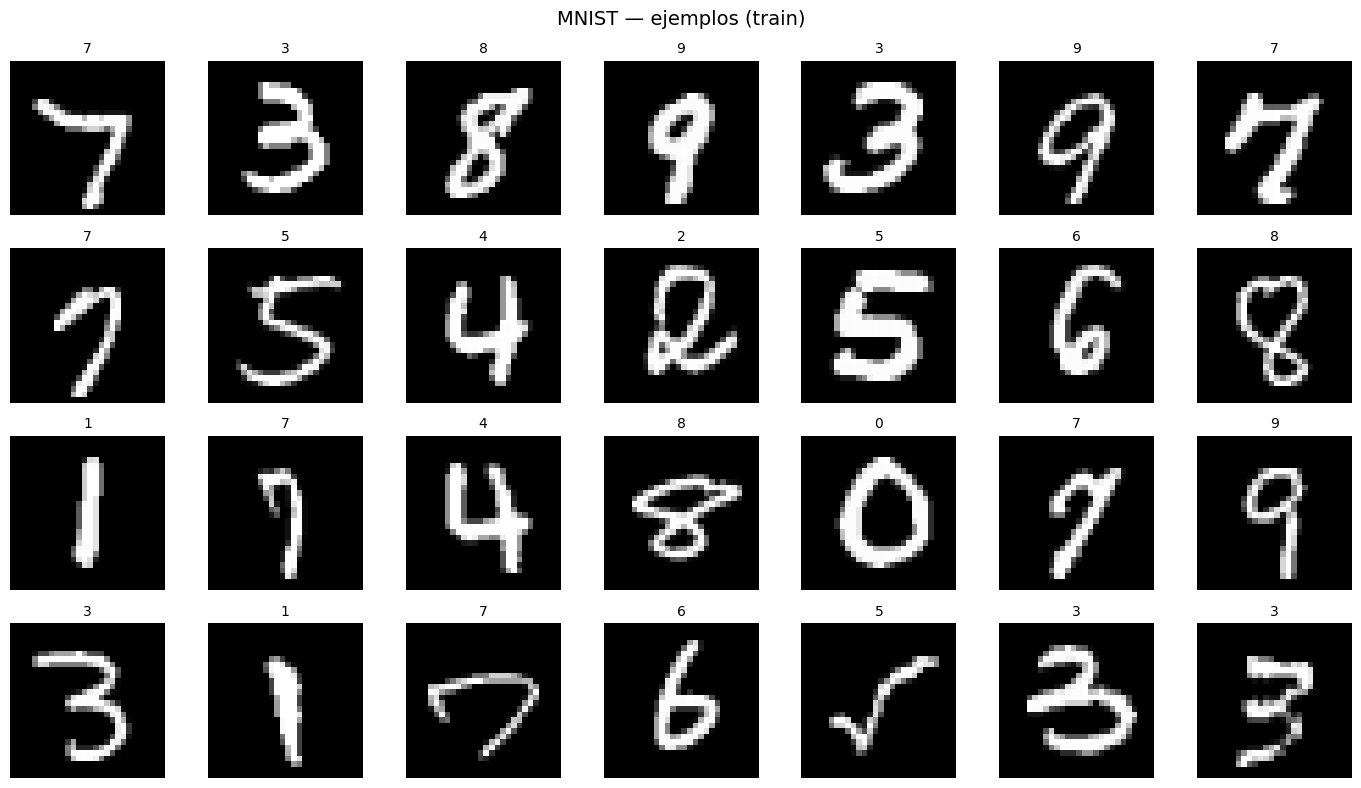

MNIST shapes: (60000, 784) (10000, 784)
Train/Valid shapes: (9600, 784) (2400, 784)


In [8]:
# Carga MNIST
(Xtr, ytr), (Xte, yte) = mnist.load_data()

# Visualización
show_grid(Xtr, ytr, nrows=4, ncols=7, title="MNIST — ejemplos (train)")

# Preprocesamiento
# Normaliza a [0,1]
Xtr_f = (Xtr / 255.0).astype("float32")
Xte_f = (Xte / 255.0).astype("float32")

# Aplana (784)
Xtr_f = Xtr_f.reshape(len(Xtr_f), -1)
Xte_f = Xte_f.reshape(len(Xte_f), -1)

print("MNIST shapes:", Xtr_f.shape, Xte_f.shape)

# Para hacerlo rápido: submuestrea train
n_train_sub = 12000  # ajusta si quieres más/menos rapidez
idxs = np.random.choice(len(Xtr_f), size=n_train_sub, replace=False)
Xtr_sub, ytr_sub = Xtr_f[idxs], ytr[idxs]

# Split train/valid (hold-out interno)
X_train, X_valid, y_train, y_valid = train_test_split(
    Xtr_sub, ytr_sub, test_size=0.2, random_state=RANDOM_STATE, stratify=ytr_sub
)
print("Train/Valid shapes:", X_train.shape, X_valid.shape)


In [9]:
pipe = make_knn_pipeline()

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # Manhattan o Euclidiana
}

gcv = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
gcv.fit(X_train, y_train)

print("MEJOR CONFIG:", gcv.best_params_, "| CV acc =", gcv.best_score_)
best_mnist = gcv.best_estimator_

# Validación holdout (valid set)
best_mnist.fit(X_train, y_train)
y_pred_val = best_mnist.predict(X_valid)
print("Valid accuracy:", accuracy_score(y_valid, y_pred_val))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
MEJOR CONFIG: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'} | CV acc = 0.926875
Valid accuracy: 0.9329166666666666


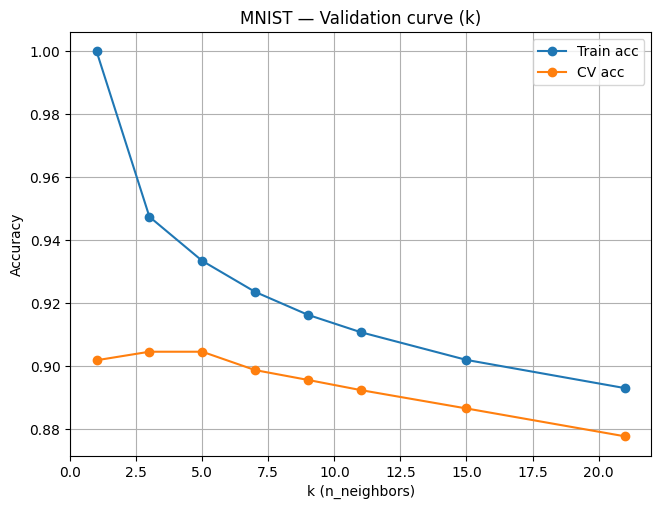

In [10]:
k_values = [1, 3, 5, 7, 9, 11, 15, 21]

train_scores, val_scores = validation_curve(
    make_knn_pipeline(), X_train, y_train,
    param_name="knn__n_neighbors",
    param_range=k_values,
    cv=3, scoring="accuracy", n_jobs=-1
)

train_acc = train_scores.mean(axis=1)
val_acc = val_scores.mean(axis=1)

plt.plot(k_values, train_acc, marker="o", label="Train acc")
plt.plot(k_values, val_acc, marker="o", label="CV acc")
plt.xlabel("k (n_neighbors)"); plt.ylabel("Accuracy")
plt.title("MNIST — Validation curve (k)")
plt.legend(); plt.show()


MNIST — Test accuracy: 0.9356


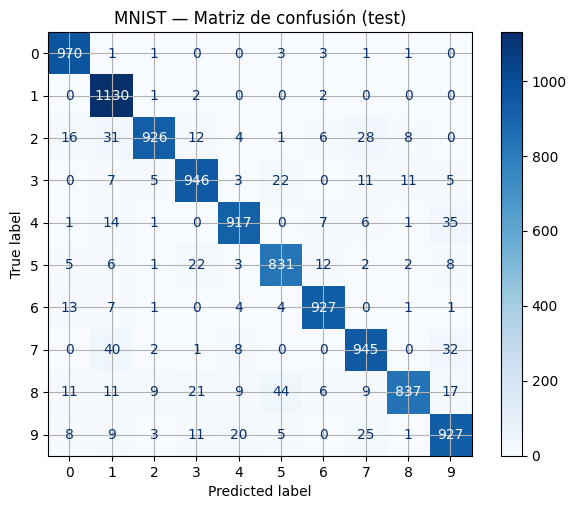

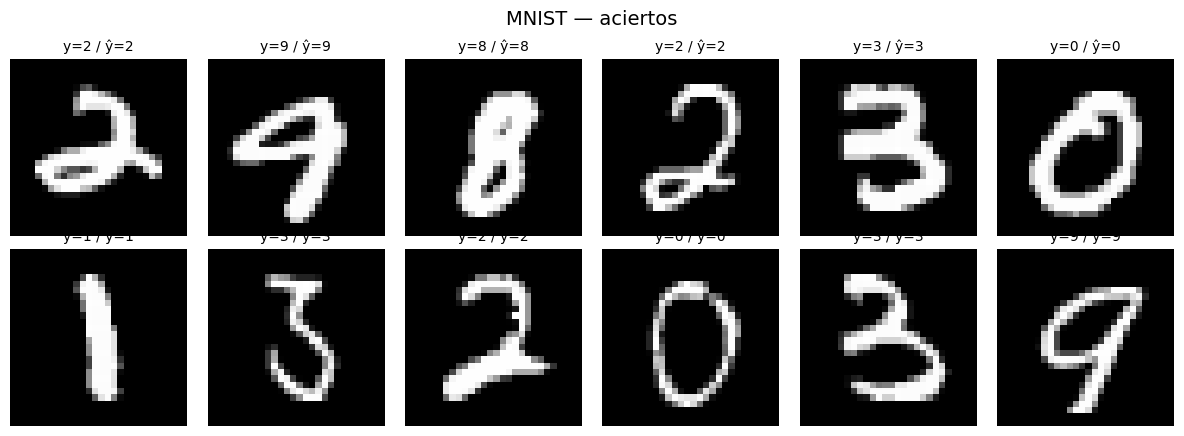

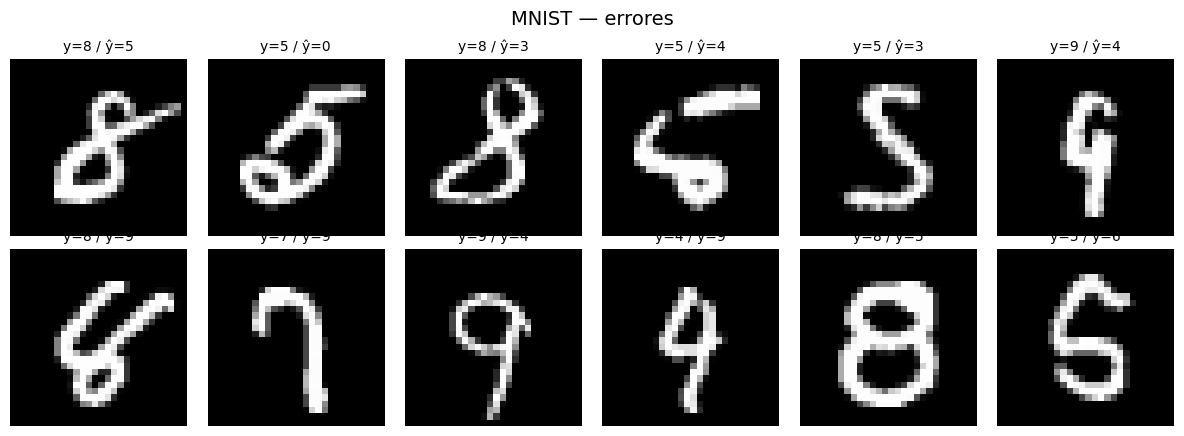

In [11]:
best_mnist.fit(Xtr_sub, ytr_sub)  # entrena con todo el subtrain
y_test_pred = best_mnist.predict(Xte_f)
test_acc = accuracy_score(yte, y_test_pred)
print("MNIST — Test accuracy:", test_acc)

ConfusionMatrixDisplay.from_predictions(yte, y_test_pred, cmap="Blues")
plt.title("MNIST — Matriz de confusión (test)"); plt.show()

# Mosaico de predicciones acertadas/erróneas
def show_preds(images28, y_true, y_pred, n=12, correct=True, title=None):
    idxs = np.where((y_true == y_pred) if correct else (y_true != y_pred))[0]
    if len(idxs) == 0:
        print("No hay ejemplos para mostrar.")
        return
    idxs = np.random.choice(idxs, size=min(n, len(idxs)), replace=False)
    rows = int(np.ceil(n/6))
    fig, axes = plt.subplots(rows, 6, figsize=(12, 2.2*rows))
    axes = axes.ravel()
    for ax, i in zip(axes, idxs):
        ax.imshow(images28[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"y={y_true[i]} / ŷ={y_pred[i]}", fontsize=10)
    if title: fig.suptitle(title, fontsize=14)
    plt.tight_layout(); plt.show()

show_preds(Xte, yte, y_test_pred, n=12, correct=True, title="MNIST — aciertos")
show_preds(Xte, yte, y_test_pred, n=12, correct=False, title="MNIST — errores")
